# Preamble and Code

In [1]:
import numpy as np
from quantecon.distributions import BetaBinomial
from numba import jit

# A default utility function

@jit
def u(c, sigma):
    if c > 0:
        return (c**(1 - sigma) - 1) / (1 - sigma)
    else:
        return -10e6


class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self, alpha=0.2,    # Job separation rate
                        beta=0.98,   # Discount rate
                        gamma=0.7,   # Job offer rate
                        c=6.0,       # Unemployment compensation
                        sigma=2.0,   # Utility parameter
                        w_vec=None,  # Possible wage values
                        p_vec=None): # Probabilities over w_vec

        self.alpha, self.beta, self.gamma, self.c = alpha, beta, gamma, c
        self.sigma = sigma

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vec is None:
            n = 60  # number of possible outcomes for wage
            self.w_vec = np.linspace(10, 20, n)     # wages between 10 and 20
            a, b = 600, 400  # shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()  
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec

@jit
def _update_bellman(alpha, beta, gamma, c, sigma, w_vec, p_vec, V, V_new, U):
    """
    A jitted function to update the Bellman equations.  Note that V_new is
    modified in place (i.e, modified by this function).  The new value of U is
    returned.

    """
    for w_idx, w in enumerate(w_vec):
        # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, sigma) + beta * ((1 - alpha) * V[w_idx] + alpha * U)

    U_new = u(c, sigma) + beta * (1 - gamma) * U + \
                    beta * gamma * np.sum(np.maximum(U, V) * p_vec)

    return U_new


def solve_mccall_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations 
    
    Parameters
    ----------
    mcm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """

    V = np.ones(len(mcm.w_vec))  # Initial guess of V
    V_new = np.empty_like(V)     # To store updates to V
    U = 1                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        U_new = _update_bellman(mcm.alpha, mcm.beta, mcm.gamma, 
                mcm.c, mcm.sigma, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1
    
    return V, U


In [147]:
mcm = McCallModel()

In [148]:
solve_mccall_model(mcm)

(array([ 45.56550882,  45.57322487,  45.58068793,  45.58791025,
         45.59490329,  45.6016778 ,  45.60824386,  45.61461095,
         45.62078798,  45.62678333,  45.6326049 ,  45.63826014,
         45.64375608,  45.64909935,  45.65429623,  45.65935266,
         45.66427425,  45.66906632,  45.67373393,  45.67828185,
         45.68271463,  45.68703659,  45.69125184,  45.69536428,
         45.69937763,  45.70329541,  45.70712102,  45.71085765,
         45.71450839,  45.71807616,  45.72156375,  45.72497384,
         45.72830898,  45.73157162,  45.73476409,  45.73788864,
         45.74094741,  45.74394246,  45.74687575,  45.74974918,
         45.75256456,  45.75532363,  45.75802807,  45.76067948,
         45.7632794 ,  45.76582933,  45.76833069,  45.77078485,
         45.77319314,  45.77555683,  45.77787715,  45.78015528,
         45.78239237,  45.7845895 ,  45.78674776,  45.78886814,
         45.79095165,  45.79299924,  45.79501182,  45.7969903 ]),
 45.62326313513024)

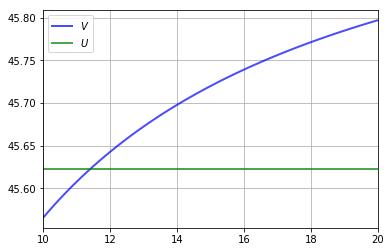

In [4]:
import matplotlib.pyplot as plt

mcm = McCallModel()
V, U = solve_mccall_model(mcm)

fig, ax = plt.subplots()

ax.plot(mcm.w_vec, V, 'b-', lw=2, alpha=0.7, label='$V$')
ax.plot(mcm.w_vec, [U]*len(mcm.w_vec), 'g-', lw=2, alpha=0.7, label='$U$')
ax.set_xlim(min(mcm.w_vec), max(mcm.w_vec))
ax.legend(loc='upper left')
ax.grid()

plt.show()

In [5]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.

    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.

    If v(w) < U for all w, then w_bar is set to np.inf.
    
    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False)
        Return the value functions as well 

    Returns
    -------
    w_bar : scalar
        The reservation wage
        
    """

    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V - U, 0)  

    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar, V, U

In [6]:
compute_reservation_wage(mcm)

11.525423728813559

# My Solution to Exercise 1

## The Reservation Wage and Unemployment Compensation

In [127]:
c_vec = np.linspace(2,12,25)

In [128]:
mcms = [McCallModel(c = c) for c in c_vec]

In [129]:
w_bars = np.asarray([compute_reservation_wage(mcm) for mcm in mcms])

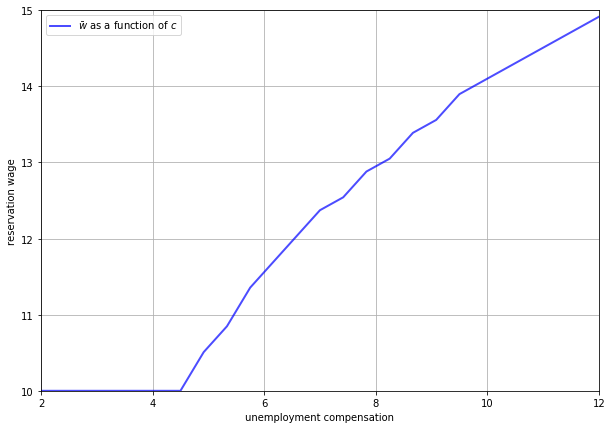

In [130]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.plot(c_vec, w_bars, 'b', lw = 2, alpha = .7, label=r'$\bar w$ as a function of $c$')
ax.set_xlim(2, 12)
ax.set_ylim(10, 15)
ax.set_xlabel('unemployment compensation')
ax.set_ylabel('reservation wage')
ax.legend()
ax.grid()
plt.show()

## The Reservation Wage and Discounting

In [124]:
b_vec = np.linspace(.8,1,25)
wbar_vec = np.empty_like(b_vec)
mcm = McCallModel()

In [125]:
for i, b in enumerate(b_vec):
    mcm.beta = b
    wbar_vec[i] = compute_reservation_wage(mcm)

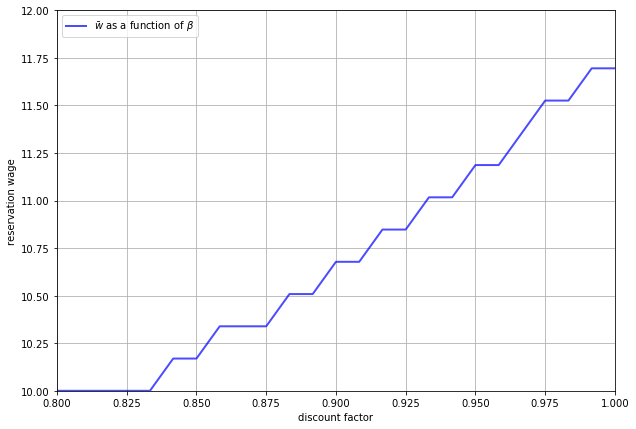

In [126]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.plot(b_vec, wbar_vec, 'b', lw = 2, alpha = .7, label=r'$\bar w$ as a function of $\beta$')
ax.set_xlim(0.8, 1)
ax.set_ylim(10, 12)
ax.set_xlabel('discount factor')
ax.set_ylabel('reservation wage')
ax.legend(loc = 'upper left')
ax.grid()
plt.show()

## The Reservation Wage and Job Destruction

In [118]:
a_vec = np.linspace(0.05,0.50,25)
wbar_vec = np.empty_like(b_vec)
mcm = McCallModel()

In [119]:
for i, a in enumerate(a_vec):
    mcm.alpha = a
    wbar_vec[i] = compute_reservation_wage(mcm)

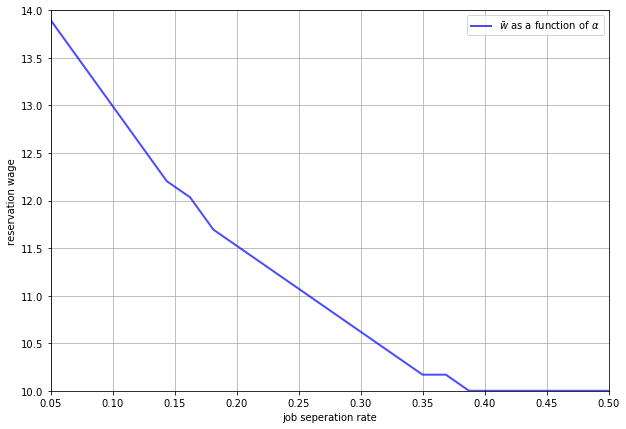

In [122]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.plot(a_vec, wbar_vec, 'b', lw = 2, alpha = .7, label=r'$\bar w$ as a function of $\alpha$')
ax.set_xlim(0.05, 0.5)
ax.set_ylim(10, 14)
ax.set_xlabel('job seperation rate')
ax.set_ylabel('reservation wage')
ax.legend(loc = 'upper right')
ax.grid()
plt.show()

# Text Solution to Exercise 1

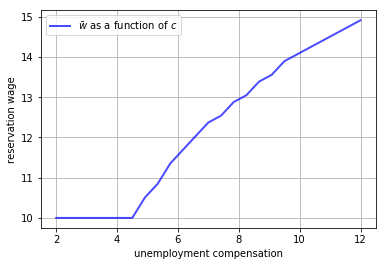

In [131]:
grid_size = 25  
c_vals = np.linspace(2, 12, grid_size)  # values of unemployment compensation
w_bar_vals = np.empty_like(c_vals)

mcm = McCallModel()

fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set_xlabel('unemployment compensation')
ax.set_ylabel('reservation wage')
txt = r'$\bar w$ as a function of $c$'
ax.plot(c_vals, w_bar_vals, 'b-', lw=2, alpha=0.7, label=txt)
ax.legend(loc='upper left')
ax.grid()

plt.show()

# My Solution to Exercise 2

In [144]:
grid_size = 25
gamma_vals = np.linspace(0.05, 0.95, grid_size)
wbar_vec = np.empty_like(b_vec)
mcm = McCallModel()

In [145]:
for i, g in enumerate(gamma_vals):
    mcm.gamma = g
    wbar_vec[i] = compute_reservation_wage(mcm)

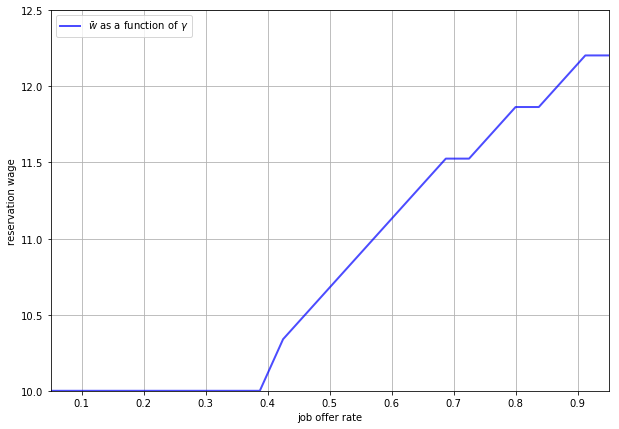

In [146]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.plot(gamma_vals, wbar_vec, 'b', lw = 2, alpha = .7, label=r'$\bar w$ as a function of $\gamma$')
ax.set_xlim(0.05, 0.95)
ax.set_ylim(10, 12.5)
ax.set_xlabel('job offer rate')
ax.set_ylabel('reservation wage')
ax.legend(loc = 'upper left')
ax.grid()
plt.show()

Reservation wage increases in the job offer rate. This makes intuitive sense because an easier ability to conduct a job search should imply that workers holdout for higher wages.

## Text Solution to Exercise 2

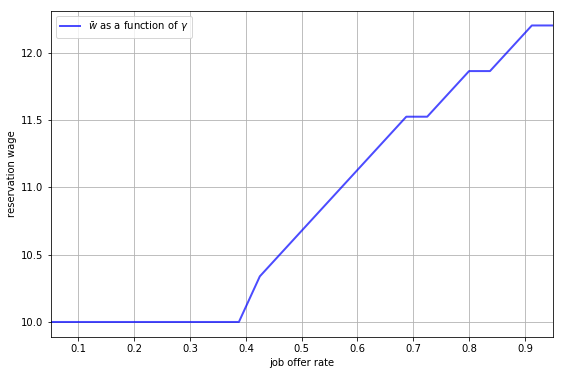

In [143]:
import matplotlib.pyplot as plt

grid_size = 25  
gamma_vals = np.linspace(0.05, 0.95, grid_size)  
w_bar_vals = np.empty_like(gamma_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize=(9, 6))

for i, gamma in enumerate(gamma_vals):
    mcm.gamma = gamma
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set_xlabel('job offer rate')
ax.set_ylabel('reservation wage')
ax.set_xlim(gamma_vals.min(), gamma_vals.max())
txt = r'$\bar w$ as a function of $\gamma$'
ax.plot(gamma_vals, w_bar_vals, 'b-', lw=2, alpha=0.7, label=txt)
ax.legend(loc='upper left')
ax.grid()

plt.show()